In [50]:
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import requests


In [2]:
subcorpora = ['archaic', 'classical', 'roman', 'christian', 'jewish']

religion_final = ["θεός", "Ζεύς", "εὐσεβής", 'ἱερός']
morality_final = ["ἀγαθός", "ἀρετή", "δίκαιος", "τιμή"]

In [51]:
lsj = requests.get("https://raw.githubusercontent.com/perseids-project/lsj-js/master/src/dictionaries/dictionary.json").json()

In [53]:
for key in religion_final + morality_final:
    try:
        print(lsj[key])
    except:
        print(key + " not found")

<b>θεός</b>, <i>ὁ</i>, Boeot. <i>θιός</i>, Lacon. <i>σιός</i> (v. infr.), Cypr., Cret. <i>θιός</i> Inscr.Cypr.135.27 H., Leg.Gort.1.1, Dor. also <i>θεύς</i> Call.Cer.58; acc. <i>θεῦν</i> v.l. ib.130; voc. (only late) <i>θεός</i>, also <i>θεέ</i> LXXDe.3.24, Ev.Matt.27.46, PMag.Lond.121.529, etc.; but classical in compd. names, <i>Ἀμφίθεε</i>, <i>Τιμόθεε</i>:—God, the Deity, in general sense, both sg. and pl. (<i>εἰ</i> <i>καὶ</i> <i>ἐπὶ</i> <i>θεοὺς</i> <i>καὶ</i> <i>ἔτι</i> <i>μᾶλλον</i> <i>ἐπὶ</i> <i>θεὸν</i> <i>ἁρμόζει</i> <i>μεταφέρειν</i> Plot.6.8.1), <i>θ</i>. <i>δὲ</i> <i>τὸ</i> <i>μὲν</i> <i>δώσει</i> <i>τὸ</i> <i>δ’</i> <i>ἐάσει</i> God will grant . . , Od.14.444; <i>οὐδέ</i> <i>κεν</i> <i>ἄλλως</i> <i>οὐδὲ</i> <i>θ</i>. <i>τεύξειε</i> 8.177, cf. 3.231, Il.13.730 (also <i>θεὸς</i> <i>Ζεύς</i> Od.4.236, 14.327); <i>θ</i>. <i>καὶ</i> <i>ἀγαθὴ</i> <i>τύχη</i> Pl.Lg.757e, cf. Timocl.3 D.; <i>σὺν</i> <i>θεῷ</i> Il.9.49, S.Aj.765, etc. (less freq. <i>ξὺν</i> <i>τῷ</i> <i>θ</i>. ib.3

In [60]:
vectors_seed1_dict = {}
vectors_seed2_dict = {}
for sub in subcorpora:
    vectors_seed1 = KeyedVectors.load("../data/large_data/vectors_{}_seed1.kv".format(sub))
    vectors_seed1_dict[sub] = vectors_seed1
    vectors_seed2 = KeyedVectors.load("../data/large_data/vectors_{}_seed2.kv".format(sub))
    vectors_seed2_dict[sub] = vectors_seed2

In [61]:
vectors_seed1_dict["archaic"]["ἀγαθός"]

array([ 1.524826  , -0.4050309 , -0.8123989 , -1.229036  ,  0.47232363,
       -1.2184308 ,  1.2349117 , -0.58043176, -1.5812721 ,  0.40092328,
       -0.23443414, -0.7422254 , -1.6245396 , -0.11819018, -0.8666356 ,
       -0.31406757, -0.11347961,  0.81643087,  0.01617606, -0.2674281 ,
       -0.23681837, -1.7048237 ,  0.6645272 , -1.3287183 , -0.30883557,
       -0.6528886 ,  1.3756114 , -1.0039988 , -0.3911665 ,  0.5781188 ,
       -0.762231  ,  0.340836  ,  0.42102823, -0.755939  , -1.8750805 ,
       -2.212931  ,  0.57479507, -1.1919935 , -1.6228495 ,  1.2022885 ,
       -0.6097263 , -0.13649613,  0.88312954,  0.01831929,  0.7746038 ,
       -0.04007259,  1.1371372 ,  1.4587787 , -0.27853736, -0.0580341 ,
       -0.41654924,  1.3935888 ,  0.75251436,  1.1960874 ,  1.0364802 ,
       -0.7729692 , -0.39878   , -0.02832877, -0.6144726 , -0.68392473,
       -0.69778067, -0.63134027, -0.29135162,  1.3023754 ,  0.28626293,
        1.0659131 , -0.8471497 ,  0.8646592 , -0.7661484 ,  1.40

In [72]:
n = 20
dfs = {}
for sub in subcorpora:
    sub_data = {}
    for key in religion_final + morality_final:
        neighbors_tups = vectors_seed2_dict[sub].most_similar(key, topn=n)
        tups_formatted = [tup[0] + " ({})".format(str(np.round(tup[1], 2))) for tup in neighbors_tups]
        sub_data[sub + " " + key] =  tups_formatted
    sub_data_df = pd.DataFrame(sub_data)
    dfs[sub] = sub_data_df


In [79]:
dfs["roman"]

,roman θεός,roman Ζεύς,roman εὐσεβής,roman ἱερός,roman ἀγαθός,roman ἀρετή,roman δίκαιος,roman τιμή
0,θεῖος (0.59),Ἥφαιστος (0.53),ὅσιος (0.64),τέμενος (0.67),σπουδαῖος (0.56),ἀνδρεία (0.62),εὐσεβής (0.57),εὐεργετέω (0.61)
1,εὐχή (0.59),Ἀπόλλων (0.52),σωτήρ (0.58),ναός (0.65),φρόνιμος (0.55),σωφροσύνη (0.58),ὅσιος (0.54),δωρεά (0.59)
2,Ἀπόλλων (0.56),θεά (0.52),δίκαιος (0.57),ἱερόν (0.64),αἱρετός (0.54),ἐγκράτεια (0.58),ἄδικος (0.54),εὐεργεσία (0.58)
3,δαίμων (0.53),Λητώ (0.52),νομοθέτης (0.56),βωμός (0.61),φευκτός (0.52),δικαιοσύνη (0.58),κριτής (0.53),φιλανθρωπία (0.58)
4,τελετή (0.53),Ῥέα (0.52),σώφρων (0.53),ξόανον (0.6),ἐπαινετός (0.49),εὐδαιμονία (0.57),δικαιοσύνη (0.53),εὐεργέτης (0.57)
5,σωτήρ (0.52),Ποσειδῶν (0.51),ἀσεβής (0.52),Ἀθήνη (0.6),κακός (0.48),ἐπαινετός (0.56),πολιτεύω (0.53),τιμάω (0.57)
6,εὔχομαι (0.52),Ἀθήνη (0.51),φρόνιμος (0.51),Ἐλευσίς (0.57),βέλτιστος (0.48),αἱρετός (0.51),εὐεργέτης (0.52),γέρας (0.56)
7,θεά (0.51),Τιτάν (0.49),εὐσέβεια (0.51),Ἄρτεμις (0.57),δίκαιος (0.47),σύνεσις (0.5),μεγαλόψυχος (0.52),ἔπαινος (0.54)
8,μαντικός (0.51),θεός (0.49),θεός (0.5),καθιερόω (0.57),δικαιοσύνη (0.46),μεγαλοψυχία (0.5),νομοθέτης (0.52),εὔνοια (0.53)
9,ἀθάνατος (0.5),Ἑρμῆς (0.49),μακάριος (0.5),ἐπίκλησις (0.56),βελτίων (0.44),εὐγένεια (0.5),ἀδικέω (0.52),ἱερωσύνη (0.52)


In [ ]:
μάκαρ (0.31) μέγας (0.29) ἀθάνατος (0.33) ἀρχή (0.28)
εὔδοξος (0.27)


morality:
δικαιοσύνη
σωφροσύνη (0.57)
φίλος (0.34)
ἁμαρτία (0.35) πονηρός (0.3) κακός (0.37)
ἀδικέω (0.54)
ἄδικος (0.47)
τιμάω (0.5)
εὐεργεσία (0.44)

religion:
ἵλαος (of gods),
εὐχή (prayer)
θεά,
θεοφιλής,
ἀσεβέω,
ἀσεβής, εὐσέβεια, θύω,
δαίμων (0.52) δαιμόνιον (0.42) τελετή (0.42) θεῖος (0.39)
ἱερόν (0.27) εὔχομαι (0.25)

In [74]:
dfs["classical"]

,classical θεός,classical Ζεύς,classical εὐσεβής,classical ἱερός,classical ἀγαθός,classical ἀρετή,classical δίκαιος,classical τιμή
0,δαίμων (0.52),Ἀσκληπιός (0.52),ὅσιος (0.49),τέμενος (0.59),σπουδαῖος (0.56),σωφροσύνη (0.57),ἀδικέω (0.54),τιμάω (0.5)
1,εὐσεβής (0.45),Ἥρα (0.5),ἀνόσιος (0.46),ἱερόν (0.56),ἀρετή (0.53),ἀνδρεία (0.54),οὗτος (0.47),φιλοτιμία (0.45)
2,δαιμόνιον (0.42),μῆτις (0.49),στυγέω (0.45),βωμός (0.54),ὠφέλιμος (0.51),ἀγαθός (0.53),ἄδικος (0.47),γέρας (0.45)
3,Ἀπόλλων (0.42),Διόνυσος (0.49),θεός (0.45),Πύθιος (0.51),κακός (0.51),δικαιοσύνη (0.52),δημοτικός (0.47),ἀξία (0.44)
4,τελετή (0.42),Ποσειδῶν (0.48),θεοφιλής (0.44),ἄγαλμα (0.48),εὐδαιμονία (0.51),φρόνησις (0.5),εὔορκος (0.45),εὐεργεσία (0.44)
5,θεῖος (0.39),λίσσομαι (0.46),ἀσεβέω (0.43),Ἄρτεμις (0.47),ἐπιεικής (0.49),ἐπαινετός (0.49),πράσσω (0.45),ἔπαινος (0.43)
6,ἵλαος (0.39),Ἀφροδίτη (0.46),εὐσέβεια (0.42),Ἀθήνη (0.47),χρηστός (0.49),κτῆσις (0.47),ἀγαθός (0.45),δωρεά (0.42)
7,ὅσιος (0.38),Ἥφαιστος (0.45),ἀσεβής (0.42),θύω (0.45),καλός (0.49),σπουδαῖος (0.47),νόμος (0.45),κτῆσις (0.41)
8,εὐχή (0.38),θεά (0.45),σεμνός (0.39),Ἀμφικτύονες (0.44),εὐδαίμων (0.47),εὐδαιμονία (0.46),πολίτης (0.44),προσήκω (0.41)
9,θεά (0.37),Ἀπόλλων (0.45),τελετή (0.39),Ἐλευσίνιος (0.44),φρόνιμος (0.47),καρτερία (0.46),προσήκω (0.43),κτῆμα (0.41)


In [75]:
dfs["roman"]

,roman θεός,roman Ζεύς,roman εὐσεβής,roman ἱερός,roman ἀγαθός,roman ἀρετή,roman δίκαιος,roman τιμή
0,θεῖος (0.59),Ἥφαιστος (0.53),ὅσιος (0.64),τέμενος (0.67),σπουδαῖος (0.56),ἀνδρεία (0.62),εὐσεβής (0.57),εὐεργετέω (0.61)
1,εὐχή (0.59),Ἀπόλλων (0.52),σωτήρ (0.58),ναός (0.65),φρόνιμος (0.55),σωφροσύνη (0.58),ὅσιος (0.54),δωρεά (0.59)
2,Ἀπόλλων (0.56),θεά (0.52),δίκαιος (0.57),ἱερόν (0.64),αἱρετός (0.54),ἐγκράτεια (0.58),ἄδικος (0.54),εὐεργεσία (0.58)
3,δαίμων (0.53),Λητώ (0.52),νομοθέτης (0.56),βωμός (0.61),φευκτός (0.52),δικαιοσύνη (0.58),κριτής (0.53),φιλανθρωπία (0.58)
4,τελετή (0.53),Ῥέα (0.52),σώφρων (0.53),ξόανον (0.6),ἐπαινετός (0.49),εὐδαιμονία (0.57),δικαιοσύνη (0.53),εὐεργέτης (0.57)
5,σωτήρ (0.52),Ποσειδῶν (0.51),ἀσεβής (0.52),Ἀθήνη (0.6),κακός (0.48),ἐπαινετός (0.56),πολιτεύω (0.53),τιμάω (0.57)
6,εὔχομαι (0.52),Ἀθήνη (0.51),φρόνιμος (0.51),Ἐλευσίς (0.57),βέλτιστος (0.48),αἱρετός (0.51),εὐεργέτης (0.52),γέρας (0.56)
7,θεά (0.51),Τιτάν (0.49),εὐσέβεια (0.51),Ἄρτεμις (0.57),δίκαιος (0.47),σύνεσις (0.5),μεγαλόψυχος (0.52),ἔπαινος (0.54)
8,μαντικός (0.51),θεός (0.49),θεός (0.5),καθιερόω (0.57),δικαιοσύνη (0.46),μεγαλοψυχία (0.5),νομοθέτης (0.52),εὔνοια (0.53)
9,ἀθάνατος (0.5),Ἑρμῆς (0.49),μακάριος (0.5),ἐπίκλησις (0.56),βελτίων (0.44),εὐγένεια (0.5),ἀδικέω (0.52),ἱερωσύνη (0.52)


In [76]:
dfs["christian"]

,christian θεός,christian Ζεύς,christian εὐσεβής,christian ἱερός,christian ἀγαθός,christian ἀρετή,christian δίκαιος,christian τιμή
0,πατήρ (0.68),ποιητής (0.37),ζηλωτής (0.32),θεῖος (0.35),κακός (0.42),θεωρητικός (0.42),δικαιοσύνη (0.42),χρεία (0.32)
1,πᾶς (0.61),ἄγνωστος (0.32),θεοσεβής (0.32),ἱστορία (0.35),καλός (0.41),στερέω (0.36),ἄδικος (0.39),κρατύς (0.28)
2,ἄνθρωπος (0.58),βαρούχ (0.3),Ἐπίκουρος (0.3),ἀλληγορία (0.33),θεός (0.36),σωφροσύνη (0.36),ἁμαρτάνω (0.35),χρυσός (0.28)
3,αὐτός (0.57),γεννάω (0.3),βοηθός (0.29),Ἀμβρόσιος (0.32),ἀρετή (0.36),ἀγαθός (0.36),θεός (0.34),τιμάω (0.27)
4,θεάομαι (0.55),οὗτος (0.26),φαῦλος (0.29),ἰδιωτικός (0.31),χρηστός (0.35),ἀπάθεια (0.35),ἔργον (0.33),ἄργυρος (0.26)
5,κύριος (0.54),ἐπιμιμνήσκομαι (0.26),ἀρνούμενος (0.29),ὑπαγορεύω (0.31),φαῦλος (0.33),πρακτικός (0.35),κρίσις (0.33),λογικοῦ (0.26)
6,υἱός (0.53),ποίησις (0.25),ἐπαινέω (0.29),πάνσοφος (0.31),πᾶς (0.33),ἀνδρεία (0.34),κύριος (0.33),καταφρονέω (0.25)
7,Χριστός (0.5),ὁμολογέω (0.25),ἀπατεών (0.29),σεμνός (0.31),ἄνθρωπος (0.32),ἐπιστήμη (0.31),δικαιόω (0.31),εὐάρεστος (0.25)
8,ποιέω (0.48),μόνος (0.25),εὐσεβέω (0.28),Ἀριστέας (0.29),πονηρός (0.3),θεωρία (0.3),θεοσεβής (0.31),ἄμετρος (0.24)
9,εἰμί (0.48),ὁμοιότης (0.24),ἀποστρέφω (0.27),νουθετέω (0.29),εὐάρεστος (0.3),βιόω (0.3),χρηστός (0.31),λειτουργία (0.24)


In [77]:
dfs["jewish"]

,jewish θεός,jewish Ζεύς,jewish εὐσεβής,jewish ἱερός,jewish ἀγαθός,jewish ἀρετή,jewish δίκαιος,jewish τιμή
0,κύριος (0.5),ὁσιότης (0.34),δίκαιος (0.4),ἱερόν (0.56),καλός (0.47),φαῦλος (0.5),φιλάνθρωπος (0.43),ἀξίωμα (0.4)
1,εὐλογέω (0.46),ὑπερυψοῦτε (0.3),εὐσέβεια (0.38),ναός (0.41),ἀρετή (0.44),καλοκἀγαθία (0.5),ὅσιος (0.4),τιμάω (0.39)
2,λέγω (0.45),οὐράνιος (0.3),βραβεύω (0.37),τέμενος (0.4),εὐδαιμονία (0.41),ἀγαθός (0.44),εὐσεβής (0.4),δωρεά (0.38)
3,ὕψιστος (0.42),αἰνός (0.29),ἐνθυμέομαι (0.35),ἱερή (0.39),μακάριος (0.39),εὐσέβεια (0.42),ἀγαθός (0.36),ἀξία (0.38)
4,εὐλογητός (0.4),ἀγέννητος (0.29),ἀγαθός (0.35),δημόσιος (0.37),θεός (0.39),ἀστεῖος (0.41),ἐπιεικής (0.35),πατρῷος (0.38)
5,ἀγαθός (0.39),θέω (0.29),εὐδοκία (0.34),χάλκεος (0.34),ἀστεῖος (0.39),σωφροσύνη (0.41),ἀλήθεια (0.35),προσηγορία (0.38)
6,ἐξομολογέομαι (0.39),γεν (0.28),ἀγεννήτου (0.33),Καπετώλιον (0.33),εὐνομία (0.38),ἐπίληπτος (0.41),δικαιοσύνη (0.35),ἀρχιερωσύνη (0.36)
7,ἄνθρωπος (0.38),μωαβ (0.27),ἀσεβής (0.33),ἄκρα (0.33),χρηστός (0.36),ἀίδιος (0.4),ἄδικος (0.34),θεραπεία (0.36)
8,Παντοκράτωρ (0.37),υπ (0.27),εὐσεβέω (0.32),συλάω (0.33),κρείσσων (0.36),εὐδαιμονία (0.4),μάρτυς (0.34),παραχωρέω (0.35)
9,σωτήρ (0.36),ἄσβεστος (0.27),ὅσιος (0.32),ἁγιστεία (0.32),δίκαιος (0.36),ἐγκράτεια (0.4),θεός (0.34),ἀμοιβή (0.35)


In [64]:
sim_score_list = []
for sub in subcorpora:
    sim_score_dict = {}
    for worda in religion_final:
        for wordb in morality_final:
            sim_score_dict[worda + "+" + wordb] = vectors_seed1_dict[sub].relative_cosine_similarity(worda, wordb, topn=10)
    sim_score_list.append(sim_score_dict)
pd.DataFrame(sim_score_list, index=subcorpora)

,θεός+ἀγαθός,θεός+ἀρετή,θεός+δίκαιος,θεός+τιμή,Ζεύς+ἀγαθός,Ζεύς+ἀρετή,Ζεύς+δίκαιος,Ζεύς+τιμή,εὐσεβής+ἀγαθός,εὐσεβής+ἀρετή,εὐσεβής+δίκαιος,εὐσεβής+τιμή,ἱερός+ἀγαθός,ἱερός+ἀρετή,ἱερός+δίκαιος,ἱερός+τιμή
archaic,-0.000023,0.024381,0.035967,0.091652,0.030804,0.019525,0.021081,0.042651,0.032911,0.037465,0.070787,0.043518,-0.012688,-0.003118,0.023105,0.017075
classical,0.055964,0.060957,0.064317,0.067111,-0.017457,0.004477,0.005693,-0.004242,0.026829,0.018885,0.084012,0.033694,-0.024509,-0.030232,-0.002137,0.018016
roman,0.049268,0.043506,0.064608,0.076463,0.007420,-0.002513,0.012545,0.019173,0.072979,0.057842,0.108125,0.061730,-0.011395,-0.017326,0.007112,0.044369
christian,0.067237,0.024052,0.069946,0.022243,0.014961,0.013529,0.021150,0.008546,0.058509,0.058172,0.054449,0.039483,-0.029570,-0.019610,-0.000656,-0.009835
jewish,0.092758,0.026555,0.093763,0.022772,-0.038570,0.022392,0.019196,-0.005671,0.095690,0.064804,0.111033,0.051365,-0.028797,0.015753,0.004642,0.002948


In [39]:
pd.DataFrame(sim_score_list, index=subcorpora)

,θεός+ἀγαθός,θεός+ἀρετή,θεός+δίκαιος,θεός+τιμή,Ζεύς+ἀγαθός,Ζεύς+ἀρετή,Ζεύς+δίκαιος,Ζεύς+τιμή,εὐσεβής+ἀγαθός,εὐσεβής+ἀρετή,εὐσεβής+δίκαιος,εὐσεβής+τιμή,ἱερός+ἀγαθός,ἱερός+ἀρετή,ἱερός+δίκαιος,ἱερός+τιμή
archaic,-0.000880,0.026163,0.040106,0.084390,0.029505,0.019189,0.022784,0.036147,0.026241,0.045222,0.075025,0.039117,-0.012050,-0.007022,0.023942,0.021087
classical,0.051757,0.035625,0.068229,0.057613,0.011783,-0.009898,0.018273,0.015798,0.055188,0.031914,0.102095,0.063153,-0.001795,-0.012499,0.023431,0.030430
roman,0.047949,0.012444,0.059147,0.064614,0.022956,0.009577,0.028825,0.047244,0.056143,0.031957,0.093501,0.059681,-0.011937,-0.008025,0.010859,0.042482
christian,0.059468,0.028094,0.048773,0.031518,0.004416,0.018472,-0.004469,0.001440,0.043907,0.056907,0.059331,0.040549,-0.015973,0.002625,0.016584,0.011847
jewish,0.058150,-0.000230,0.060639,0.004450,-0.020353,0.006539,0.060255,0.041531,0.077957,0.057969,0.116083,0.036340,-0.019512,0.012262,-0.001131,0.012577


In [40]:
for worda in religion_final:
    for wordb in morality_final:
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=100)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda, wordb)
            print(sub, worda, wordb, pair_sim_score / topn_mean)

archaic θεός ἀγαθός -0.011219891925730077
classical θεός ἀγαθός 0.6913635258597935
roman θεός ἀγαθός 0.6548308956011869
christian θεός ἀγαθός 0.9085705866854901
jewish θεός ἀγαθός 0.7663937297818753
archaic θεός ἀρετή 0.3334578495764895
classical θεός ἀρετή 0.4758645531895121
roman θεός ἀρετή 0.16994790391669165
christian θεός ἀρετή 0.42922844117490455
jewish θεός ἀρετή -0.0030352619228084577
archaic θεός δίκαιος 0.5111760551463825
classical θεός δίκαιος 0.911393977014615
roman θεός δίκαιος 0.8077604266572606
christian θεός δίκαιος 0.7451696831247011
jewish θεός δίκαιος 0.7992064919149694
archaic θεός τιμή 1.0755872642179545
classical θεός τιμή 0.76958579559352
roman θεός τιμή 0.8824258890962583
christian θεός τιμή 0.48154563256395555
jewish θεός τιμή 0.05865409329358509
archaic Ζεύς ἀγαθός 0.3714919719017637
classical Ζεύς ἀγαθός 0.15851926581166195
roman Ζεύς ἀγαθός 0.32163939258782404
christian Ζεύς ἀγαθός 0.05625065471711265
jewish Ζεύς ἀγαθός -0.2598993737109308
archaic Ζεύς ἀρετή

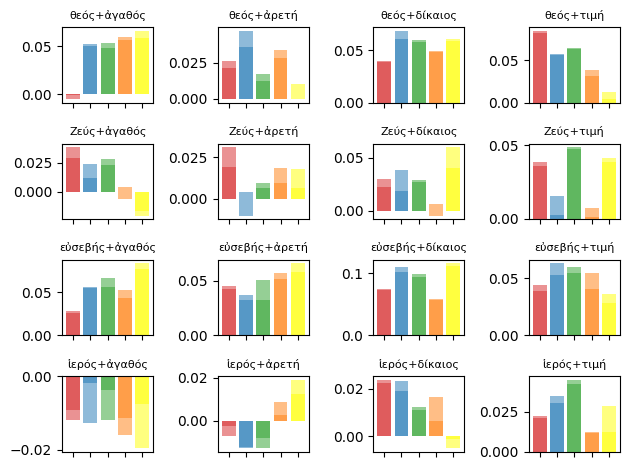

In [41]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            #topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=10)])
            #pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            #score = pair_sim_score / topn_mean
            score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

In [ ]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            #topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=10)])
            #pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            #score = pair_sim_score / topn_mean
            score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

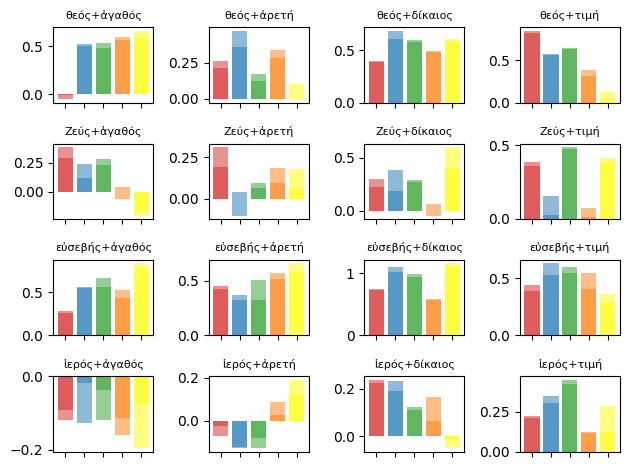

In [42]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed2_dict[sub].similarity(worda[1], wordb[1])
            #score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

In [ ]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed2_dict[sub].similarity(worda[1], wordb[1])
            #score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

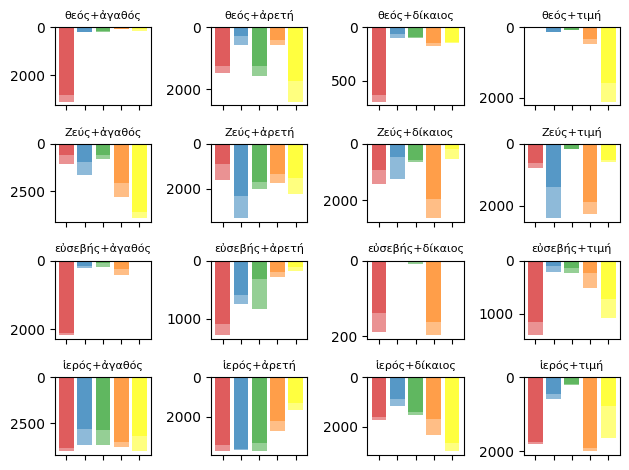

In [43]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            ordered = enumerate([tup[0] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=5000)])
            score = [tup[0] for tup in ordered if tup[1]==wordb[1]][0] + 1
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            ordered = enumerate([tup[0] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=5000)])
            score = [tup[0] for tup in ordered if tup[1]==wordb[1]][0] + 1
            #score = vectors_seed@_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])
        axs[worda[0], wordb[0]].invert_yaxis()


In [ ]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            ordered = enumerate([tup[0] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=5000)])
            score = [tup[0] for tup in ordered if tup[1]==wordb[1]][0] + 1
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            ordered = enumerate([tup[0] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=5000)])
            score = [tup[0] for tup in ordered if tup[1]==wordb[1]][0] + 1
            #score = vectors_seed@_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])
        axs[worda[0], wordb[0]].invert_yaxis()